Loaded brent oil price data (transformed)
soreted based on the date
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8981 entries, 0 to 8980
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             8981 non-null   datetime64[ns]
 1   Price            8981 non-null   float64       
 2   Log_Return       8981 non-null   float64       
 3   Rolling_Mean     8952 non-null   float64       
 4   Rolling_Std_Log  8952 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 350.9 KB
number of nans: Date                0
Price               0
Log_Return          0
Rolling_Mean       29
Rolling_Std_Log    29
dtype: int64


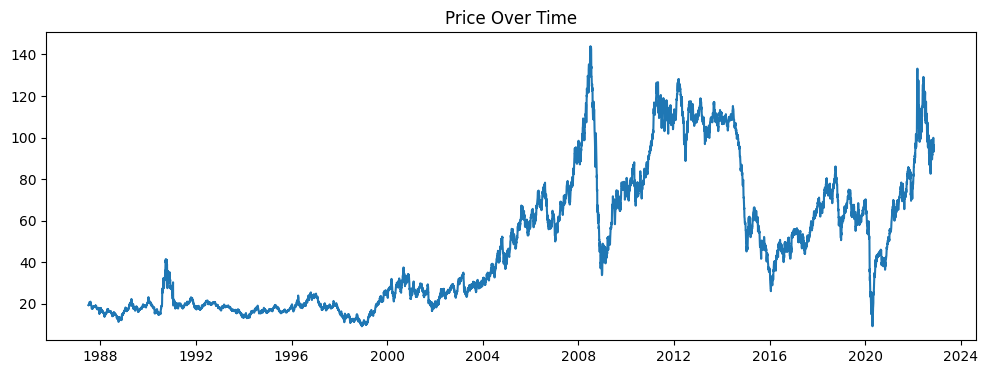

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import ruptures as rpt
import os
import sys

sys.path.append(os.path.abspath("../"))
from src.models.ruptures_config import ChangePointConfig
from src.utils.change_point_deteciton_utils import find_change_points, export_results, match_events_with_change_points, plot_change_points, calculate_segment_statistics, analyze_strong_matches


# Load data
df = pd.read_csv("../data/processed/BrentOilPrices_transformed.csv", parse_dates=["Date"])
print("Loaded brent oil price data (transformed)")
df = df.sort_values("Date").reset_index(drop=True)
print("soreted based on the date")

# nan checks
df.info()
print(f"number of nans: {df.isna().sum()}")

# Quick plot
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Price"])
plt.title("Price Over Time")
plt.show()


In [ ]:
#load event data
event_df = pd.read_csv('..data/processed/oil_events.csv', parse_dates=['start_date'])
print("Event Data loaded successfully ✅")

# fix the dates from string to date time object and replace invalid "-" separator
event_df["start_date"] = event_df["start_date"].str.replace("\u2011", "-", regex=False,) # replace non standard dash with standard dash
event_df["start_date"]= pd.to_datetime(event_df["start_date"]) # parse the date column to datetime format

print("Event start date parsed successfully ✅")
print(event_df.start_date.dtype)

Event Data loaded successfully ✅
Event start date parsed successfully ✅
datetime64[ns]


/tmp/ipython-input-1106868361.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  event_df = pd.read_csv('oil_events.csv', parse_dates=['start_date'])


# price distribution

seaborn installd
count    8981.000000
mean       48.519762
std        32.870215
min         9.100000
25%        19.100000
50%        39.050000
75%        70.360000
max       143.950000
Name: Price, dtype: float64


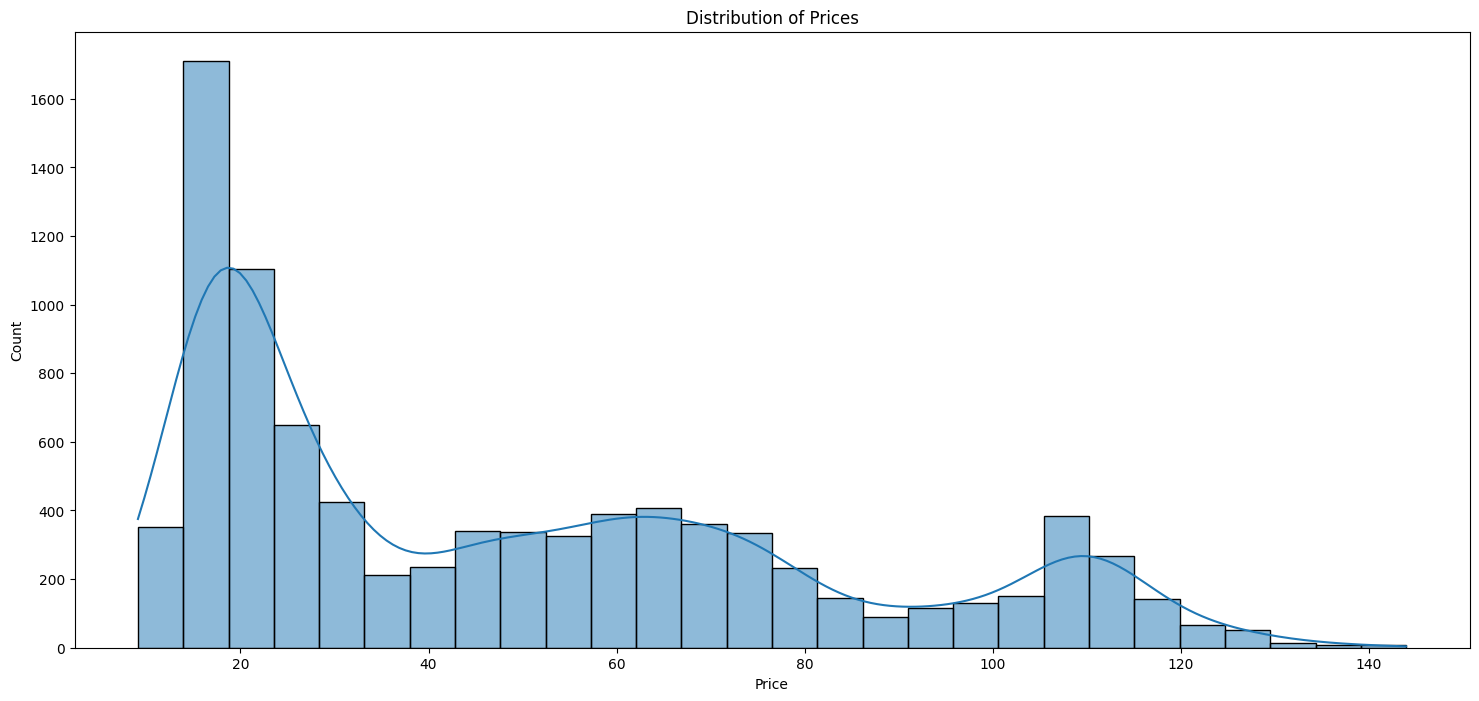

In [ ]:
print("seaborn installd")
print(df["Price"].describe())

import seaborn as sns
# plot hist plot of the prices
plt.figure(figsize=(18,8))
sns.histplot(df["Price"], kde=True, stat="count")
plt.title("Distribution of Prices")
plt.show()

# Model A – Prices with 1 Change Point
## This model detects a mean/level shift in prices using a Student-t likelihood.

In [10]:
price_data = df["Price"].values
n = len(price_data)
print(f"length of price data: {n}")

with pm.Model() as model_A:
    tau = pm.DiscreteUniform("tau", lower=0.05*n, upper=0.95*n)
    mu1 = pm.Normal("mu1", mu=np.mean(price_data), sigma=np.std(price_data)*3)
    mu2 = pm.Normal("mu2", mu=np.mean(price_data), sigma=np.std(price_data)*3)
    sigma = pm.HalfNormal("sigma", sigma=np.std(price_data)*2)
    nu = pm.Exponential("nu", 1/30)

    mu = pm.math.switch(np.arange(n) < tau, mu1, mu2)
    obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=price_data)

    trace_A = pm.sample(2000, tune=2000, target_accept=0.99)

az.summary(trace_A, var_names=["nu","mu1", "mu2", "sigma", "tau"])

length of price data: 8981


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,1.600,0.048,1.505,1.688,0.001,0.001,1435.0,1739.0,1.0
mu1,20.080,0.143,19.821,20.357,0.003,0.002,2424.0,2324.0,1.0
mu2,66.883,0.287,66.358,67.449,0.007,0.005,1865.0,1878.0,1.0
sigma,8.872,0.184,8.511,9.202,0.005,0.003,1500.0,1717.0,1.0
tau,4459.260,4.582,4453.000,4467.000,0.194,0.264,670.0,603.0,1.0


# Model B – Returns, multiple Change Point (Volatility and Mean Shifts)
## This model detects a volatility change (sigma) in log returns.
## mean is considered to be stationary and set accordingly as a prior


In [6]:
import pytensor.tensor as pt
returns_data = df["Log_Return"].values
n = len(returns_data)
K=7
with pm.Model() as model_B:

# Dirichlet prior over segment proportions
    lam = pm.Dirichlet("lam", a=np.ones(K + 1))

    # Continuous changepoint locations (scaled to time index)
    tau_cont = pm.Deterministic("tau_cont", pt.cumsum(lam)[:-1] * n)

    sigma = pm.HalfNormal("sigma", sigma=returns_data.std()*9, shape=K+1)
    mu = pm.Normal("mu", mu=0, sigma=0.05)

    # Smooth weights using sigmoid transitions
    idx = pt.arange(n)
    k = 0.05  # Controls smoothness of transitions

    # Build weights for each segment
    w = []
    for i in range(K):
        w.append(1 / (1 + pt.exp(-k * (idx - tau_cont[i]))))
    weights = [1 - w[0]]  # First segment
    for i in range(1, K):
        weights.append(w[i - 1] - w[i])  # Intermediate segments
    weights.append(w[-1])  # Last segment

    # Weighted sum of mu and sigma across segments
    #mu_piecewise = sum(mu[i] * weights[i] for i in range(K + 1))
    sigma_piecewise = sum(sigma[i] * weights[i] for i in range(K + 1))
    #nu = pm.Exponential("nu", 1/30)

    #sigma = pm.math.switch(np.arange(n) < tau, sigma1, sigma2)
    obs = pm.Normal("obs",  mu=mu, sigma=sigma_piecewise, observed=returns_data)

    trace_B = pm.sample(500, tune=500, target_accept=0.95, chains = 2, cores=2)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
az.summary(trace_B, var_names=["mu", "tau_cont","sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.000,-0.000,0.001,0.000,0.000,848.0,519.0,1.02
tau_cont[0],1399.342,1383.736,5.406,2710.832,961.727,71.221,3.0,13.0,1.97
tau_cont[1],2294.479,2208.951,18.540,4538.094,1549.285,18.858,3.0,15.0,2.12
tau_cont[2],2768.478,2636.238,114.143,5420.170,1849.116,3.496,3.0,19.0,2.01
tau_cont[3],2869.680,2649.682,132.934,5532.540,1858.520,37.015,3.0,25.0,2.23
tau_cont[4],4312.346,4005.214,243.194,8322.441,2809.334,26.926,3.0,17.0,2.22
tau_cont[5],4423.531,3912.667,493.997,8339.847,2744.445,3.641,3.0,44.0,1.96
tau_cont[6],4690.877,4062.877,612.628,8774.126,2849.800,0.469,3.0,93.0,1.83
sigma[0],0.020,0.007,0.000,0.027,0.003,0.003,7.0,17.0,1.77
sigma[1],0.035,0.057,0.000,0.124,0.020,0.024,4.0,18.0,1.88


array([[<Axes: title={'center': 'tau_cont\n0'}>,
        <Axes: title={'center': 'tau_cont\n1'}>,
        <Axes: title={'center': 'tau_cont\n2'}>],
       [<Axes: title={'center': 'tau_cont\n3'}>,
        <Axes: title={'center': 'tau_cont\n4'}>,
        <Axes: title={'center': 'tau_cont\n5'}>],
       [<Axes: title={'center': 'tau_cont\n6'}>, <Axes: >, <Axes: >]],
      dtype=object)

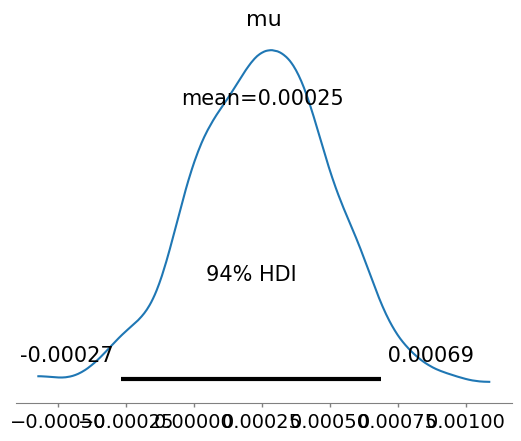

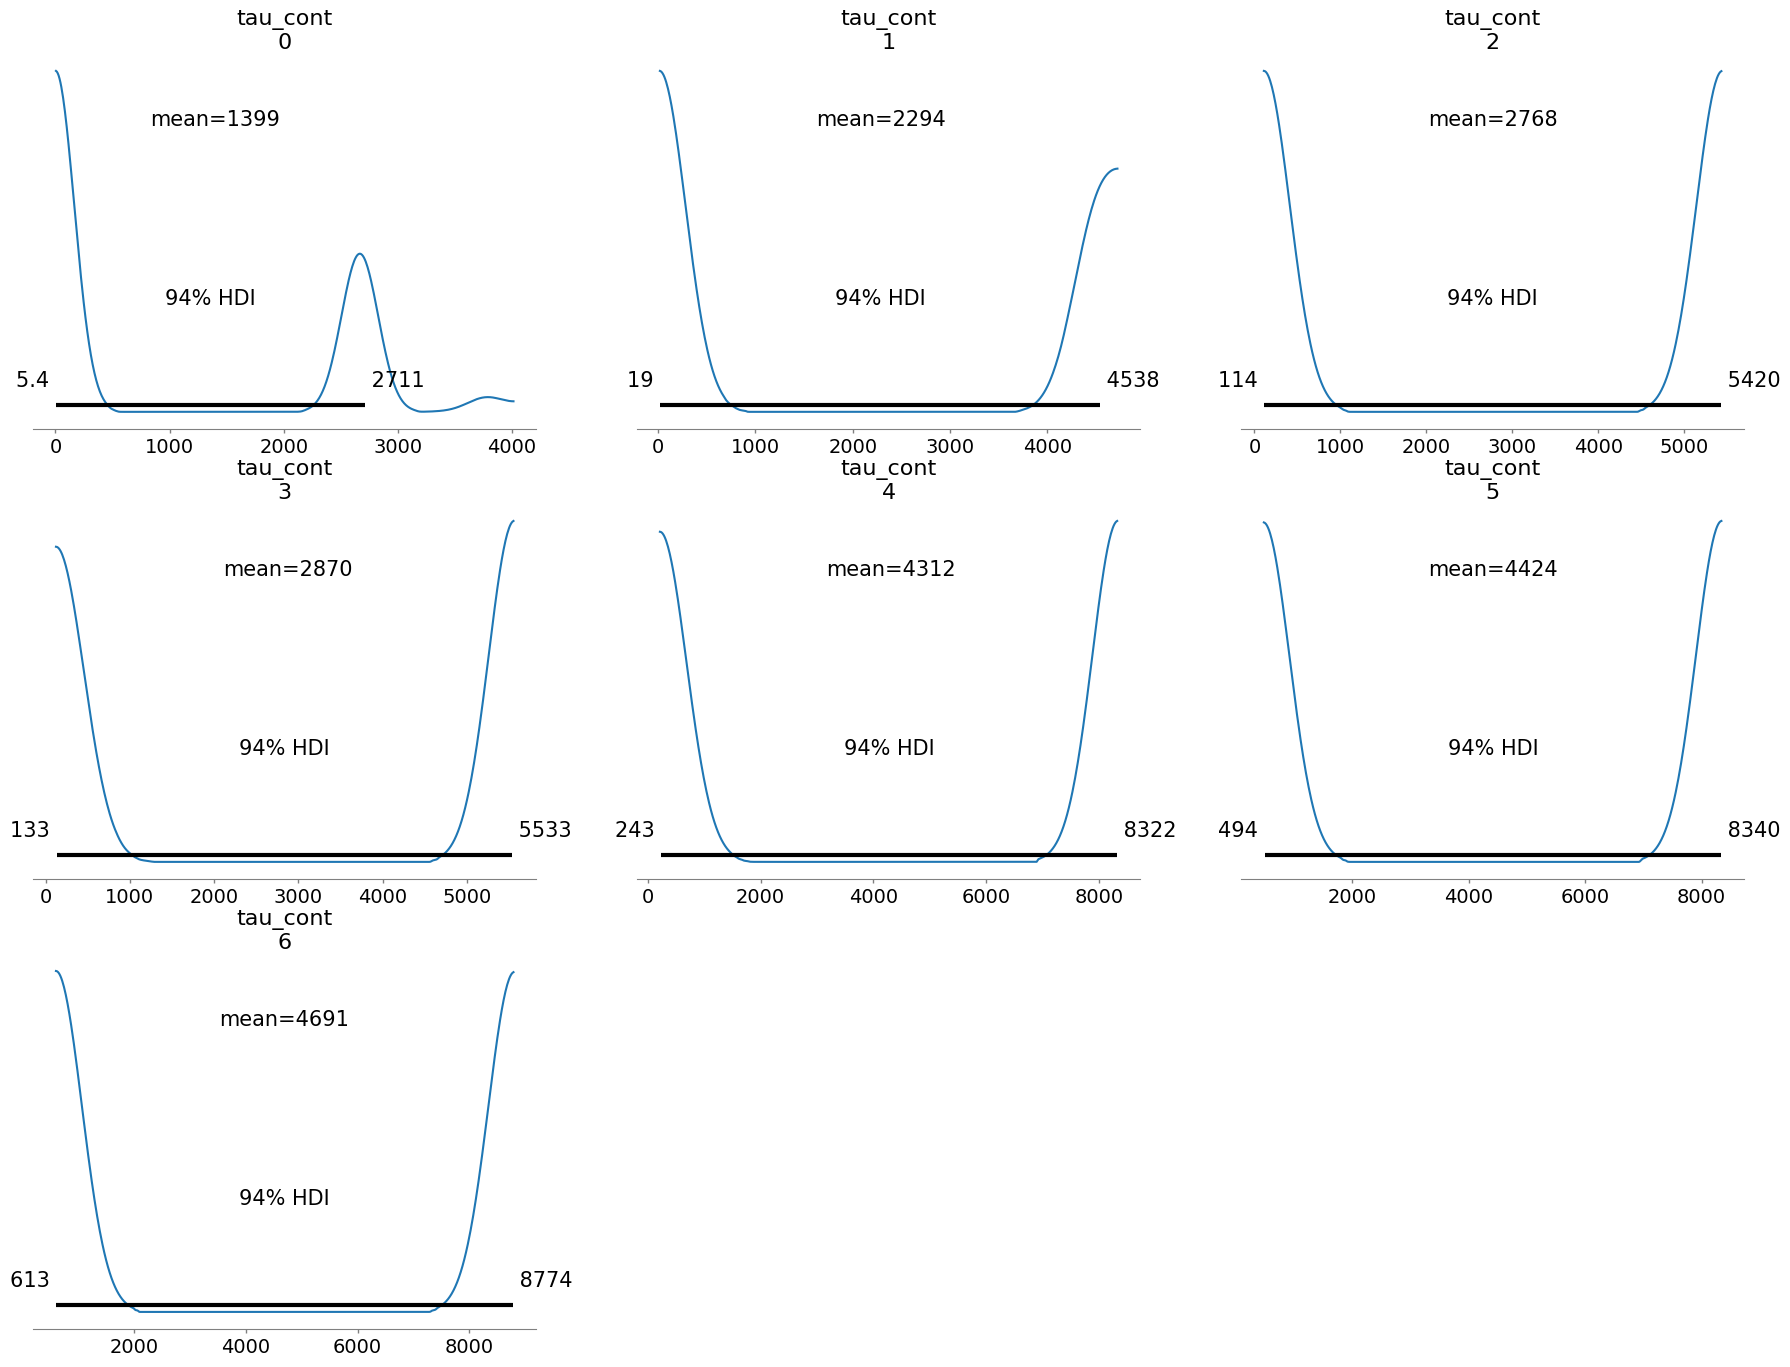

In [8]:
# plot the posterior distribution for the mean and volaility
az.plot_posterior(trace_B, var_names=["mu"])
pm.plot_posterior(trace_B, var_names=["tau_cont"])


### Posterior Diagnostics: Multi-Changepoint Model

While PyMC performs well in identifying a single changepoint, the multi-changepoint setup reveals challenges in posterior exploration. This is evident from:

- **High R-hat values**: Chains are not converging, indicating poor mixing.
- **Low ESS (Effective Sample Size)**: Very few independent samples are being drawn, suggesting the sampler is struggling to explore the posterior space efficiently.

These diagnostics suggest that PyMC may be encountering geometric bottlenecks or identifiability issues when modeling multiple regime shifts.  
➡️ **For this reason, we will pivot to using `ruptures` for multiple changepoint detection**, as it offers a more robust and scalable approach for offline segmentation without relying on MCMC sampling.


# Ruptures Change Point Detection

In [9]:
import ruptures as rpt
from datetime import datetime, timedelta
import seaborn as sns
from scipy import stats

# Set plotting style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported and configured.")

✅ Libraries imported and configured.


In [ ]:
config = ChangePointConfig()

# Prepare the time series data
log_returns_series = df['Log_Return'].values
dates_series = df['Date'].values

print("Configuration Loaded:")
print(f"Cost Function: {config.cost_function}")
print(f"Search Method: {config.search_method}")
print(f"Primary Penalty: {config.primary_penalty}")
print(f"Time Series Length: {len(log_returns_series)} points")

Configuration Loaded:
Cost Function: normal
Search Method: Pelt
Primary Penalty: 30
Time Series Length: 8981 points


# Model Training and Penalty Selection

Penalty  2: 249 change points
Penalty  5: 158 change points
Penalty 10: 80 change points
Penalty 15: 47 change points
Penalty 20: 33 change points
Penalty 30: 23 change points
Penalty 35: 20 change points


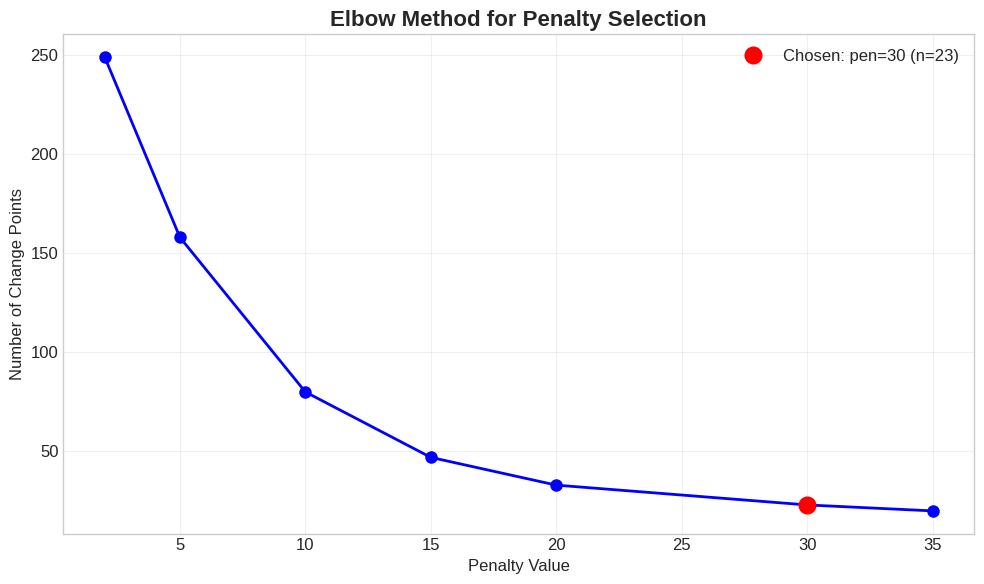


🎯 Selected penalty 30 with 23 change points


In [ ]:
# Test different penalty values
results = {}
for pen in config.penalty_values:
    bkps = find_change_points(log_returns_series, pen, config.cost_function,
                            config.min_segment_size, config.jump)
    results[pen] = {
        'n_bkps': len(bkps),
        'breakpoints': bkps,
        'dates': df['Date'].iloc[bkps].tolist()
    }
    print(f"Penalty {pen:2d}: {len(bkps):2d} change points")

# Visualize penalty selection
plt.figure(figsize=(10, 6))
penalties = list(results.keys())
n_points = [results[p]['n_bkps'] for p in penalties]
plt.plot(penalties, n_points, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Penalty Value', fontsize=12)
plt.ylabel('Number of Change Points', fontsize=12)
plt.title('Elbow Method for Penalty Selection', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Highlight our chosen penalty
chosen_idx = penalties.index(config.primary_penalty)
plt.plot(penalties[chosen_idx], n_points[chosen_idx], 'ro', markersize=12,
         label=f'Chosen: pen={config.primary_penalty} (n={n_points[chosen_idx]})')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n🎯 Selected penalty {config.primary_penalty} with {results[config.primary_penalty]['n_bkps']} change points")

# Primary inference

In [16]:

primary_bkps = find_change_points(
    log_returns_series,
    config.primary_penalty,
    config.cost_function,
    config.min_segment_size,
    config.jump
)

# Convert to dates
change_point_dates = df['Date'].iloc[primary_bkps].tolist()

print(f"🔍 Found {len(primary_bkps)} change points:")
for i, date in enumerate(change_point_dates, 1):
    print(f"  {i:2d}. {date.strftime('%Y-%m-%d')}")

# Create results dataframe for easy analysis
results_df = pd.DataFrame({
    'breakpoint_index': primary_bkps,
    'date': change_point_dates,
    'event_rank': range(1, len(primary_bkps) + 1)
})

print(f"\n Results dataframe created with {len(results_df)} change points")

/usr/local/lib/python3.12/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


🔍 Found 23 change points:
   1. 1987-12-10
   2. 1989-07-28
   3. 1990-01-03
   4. 1990-07-30
   5. 1991-03-20
   6. 1992-04-07
   7. 1993-11-24
   8. 1994-08-26
   9. 1996-01-08
  10. 1998-01-20
  11. 2001-09-14
  12. 2001-12-07
  13. 2008-08-19
  14. 2009-04-08
  15. 2010-08-27
  16. 2012-11-26
  17. 2014-11-03
  18. 2016-12-21
  19. 2018-11-01
  20. 2020-03-02
  21. 2020-05-06
  22. 2020-06-12
  23. 2022-02-25

 Results dataframe created with 23 change points


#  Results Visualization

IndexError: index 2 is out of bounds for axis 0 with size 2

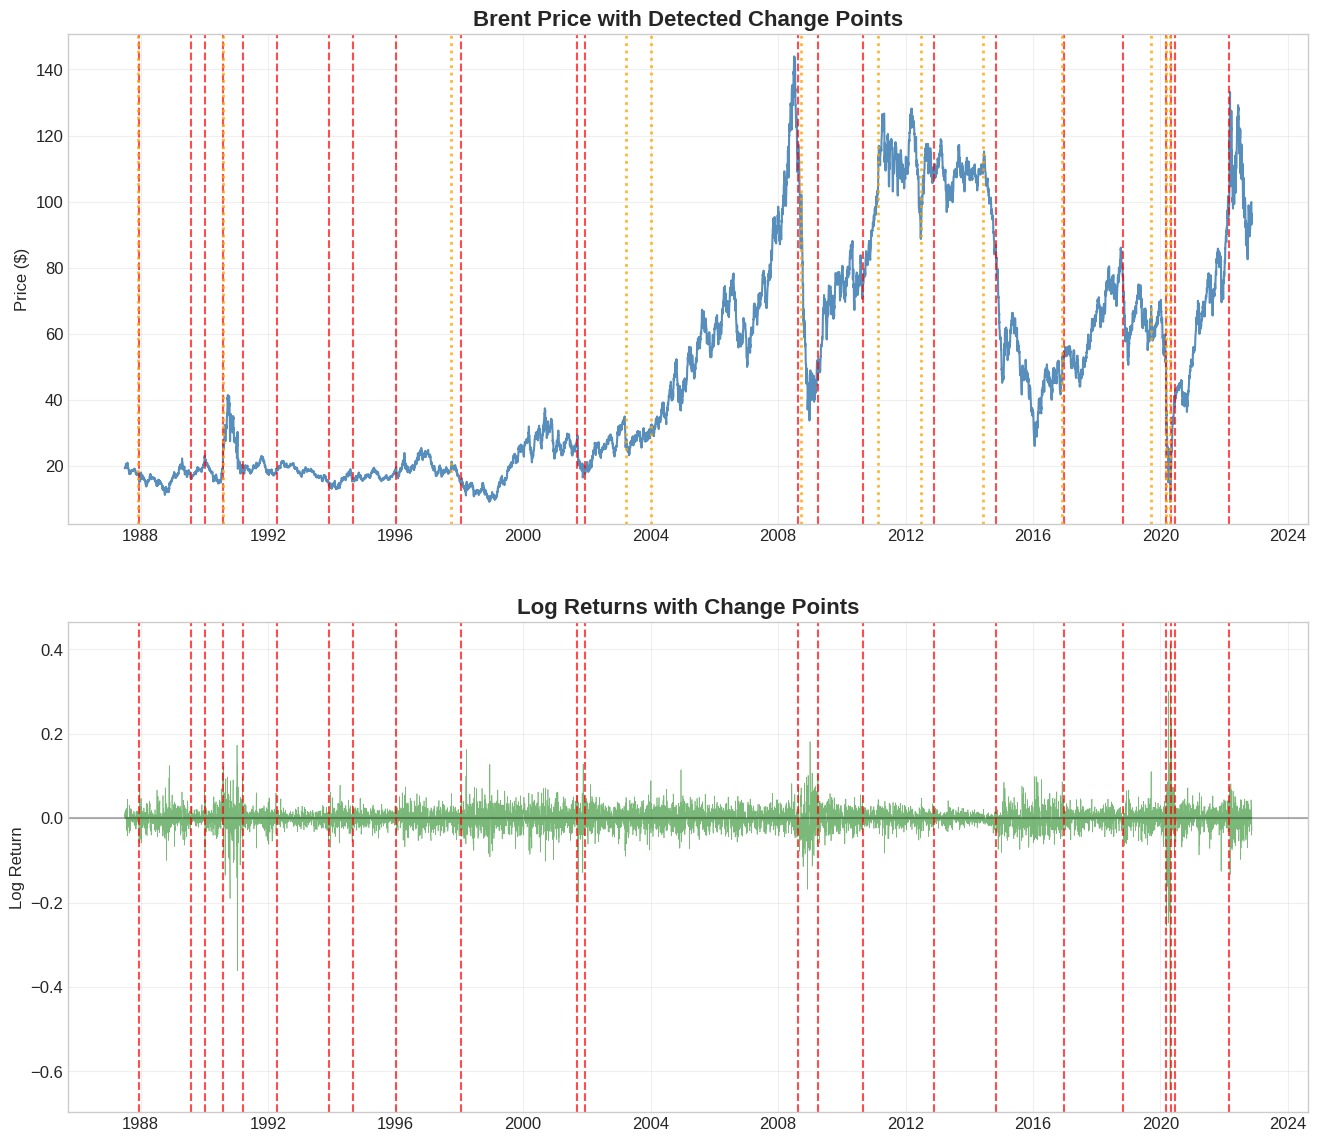

In [ ]:
# Generate the comprehensive plot
plot_change_points(df, change_point_dates, event_df)

# Quantitative Impact Analysis

In [ ]:
# Calculate segment statistics
segment_stats_df = calculate_segment_statistics(df, primary_bkps)

print("📊 Segment Statistics:")
print(segment_stats_df[['segment_id', 'start_date', 'end_date', 'duration_days',
                       'mean_price', 'volatility']].round(2))

# Calculate changes between segments
changes = []
for i in range(1, len(segment_stats_df)):
    prev_segment = segment_stats_df.iloc[i - 1]
    curr_segment = segment_stats_df.iloc[i]

    change = {
        'change_point_date': curr_segment['start_date'],
        'price_change_pct': ((curr_segment['mean_price'] - prev_segment['mean_price']) /
                            prev_segment['mean_price']) * 100,
        'volatility_change_pct': ((curr_segment['volatility'] - prev_segment['volatility']) /
                                 prev_segment['volatility']) * 100,
        'from_price': prev_segment['mean_price'],
        'to_price': curr_segment['mean_price'],
        'from_volatility': prev_segment['volatility'],
        'to_volatility': curr_segment['volatility']
    }
    changes.append(change)

changes_df = pd.DataFrame(changes)
print("\n" + "="*60)
print("📈 Change Point Impact Analysis:")
print(changes_df.round(2))

📊 Segment Statistics:
    segment_id start_date   end_date  duration_days  mean_price  volatility
0            1 1987-07-02 1987-12-09            160       18.69       20.27
1            2 1987-12-10 1989-07-27            595       16.11       36.85
2            3 1989-07-28 1990-01-02            158       18.34       16.61
3            4 1990-01-03 1990-07-27            205       17.79       34.45
4            5 1990-07-30 1991-03-19            232       28.14       90.07
5            6 1991-03-20 1992-04-06            383       19.31       25.95
6            7 1992-04-07 1993-11-23            595       18.48       18.08
7            8 1993-11-24 1994-08-25            274       15.35       32.42
8            9 1994-08-26 1996-01-05            497       16.88       21.18
9           10 1996-01-08 1998-01-19            742       19.78       31.73
10          11 1998-01-20 2001-09-13           1332       21.12       42.68
11          12 2001-09-14 2001-12-06             83       20.48   

# Event Matching and Validation

In [ ]:
# Perform matching
event_matches_df = match_events_with_change_points(change_point_dates, event_df)

print("🤝 Event-Change Point Matching Results:")
print(event_matches_df[['change_point_date', 'event_title', 'days_difference', 'match_status']])

# Calculate matching statistics
strong_matches = event_matches_df[event_matches_df['match_status'] == "✅ STRONG MATCH"]
weak_matches = event_matches_df[event_matches_df['match_status'] == "⚠️ WEAK MATCH"]
no_matches = event_matches_df[event_matches_df['match_status'] == "❌ NO MATCH"]

print(f"\n📊 Matching Summary:")
print(f"Strong matches (≤30 days): {len(strong_matches)}/{len(change_point_dates)}")
print(f"Weak matches (31-90 days): {len(weak_matches)}/{len(change_point_dates)}")
print(f"No matches (>90 days): {len(no_matches)}/{len(change_point_dates)}")

🤝 Event-Change Point Matching Results:
   change_point_date                                     event_title  \
0         1987-12-10  OPEC quota breakdown and post‑glut Brent slump   
1         1989-07-28                       Iraq’s invasion of Kuwait   
2         1990-01-03                       Iraq’s invasion of Kuwait   
3         1990-07-30                       Iraq’s invasion of Kuwait   
4         1991-03-20                       Iraq’s invasion of Kuwait   
5         1992-04-07                       Iraq’s invasion of Kuwait   
6         1993-11-24                       Iraq’s invasion of Kuwait   
7         1994-08-26        Asian financial crisis & oversupply glut   
8         1996-01-08        Asian financial crisis & oversupply glut   
9         1998-01-20        Asian financial crisis & oversupply glut   
10        2001-09-14               US invasion of Iraq (early boost)   
11        2001-12-07               US invasion of Iraq (early boost)   
12        2008-08-19     

# Strong Match Impact Analysis

In [ ]:
# Analyze strong matches
if len(strong_matches) > 0:
    strong_matches_analysis_df = analyze_strong_matches(strong_matches, changes_df, event_df)

    print("🔥 STRONG MATCH IMPACT ANALYSIS")
    print("="*80)

    for _, analysis in strong_matches_analysis_df.iterrows():
        print(f"\n📅 Event: {analysis['event_title']}")
        print(f"   Date: {analysis['event_date'].strftime('%Y-%m-%d')}")
        print(f"   Category: {analysis['event_category']}")
        print(f"   Impact Direction: {analysis['event_impact_direction']}")
        print(f"   Days from CP: {analysis['days_difference']}")
        print(f"   Price Change: {analysis['price_change_pct']:+.1f}% (${analysis['price_before']:.1f} → ${analysis['price_after']:.1f})")
        print(f"   Volatility Change: {analysis['volatility_change_pct']:+.1f}% ({analysis['volatility_before']:.1f}% → {analysis['volatility_after']:.1f}%)")
        print(f"   Influence Level: {analysis['influence_level']}")
        print(f"   Description: {analysis['event_description'][:100]}...")
        print("-" * 80)

    # Summary statistics for strong matches
    print(f"\n📊 Strong Matches Summary ({len(strong_matches_analysis_df)} events):")
    print(f"Average |Price Change|: {strong_matches_analysis_df['price_change_pct'].abs().mean():.1f}%")
    print(f"Average |Volatility Change|: {strong_matches_analysis_df['volatility_change_pct'].abs().mean():.1f}%")
    print(f"Most Common Category: {strong_matches_analysis_df['event_category'].mode().iloc[0]}")

else:
    print("No strong matches found for detailed analysis.")

🔥 STRONG MATCH IMPACT ANALYSIS

📅 Event: OPEC quota breakdown and post‑glut Brent slump
   Date: 1987-12-01
   Category: OPEC_decision
   Impact Direction: down
   Days from CP: 9
   Price Change: -13.8% ($18.7 → $16.1)
   Volatility Change: +81.8% (20.3% → 36.8%)
   Influence Level: high
   Description: OPEC’s failure to enforce quotas after the 1986 glut caused a prolonged fall in Brent to ≈ USD 18/bb...
--------------------------------------------------------------------------------

📅 Event: Iraq’s invasion of Kuwait
   Date: 1990-08-02
   Category: conflict
   Impact Direction: up
   Days from CP: 3
   Price Change: +58.2% ($17.8 → $28.1)
   Volatility Change: +161.5% (34.4% → 90.1%)
   Influence Level: very_high
   Description: Saddam’s 1990 invasion removed ~4.3 mb/d from supply; Brent **roughly doubled** from ~USD 17 to **ov...
--------------------------------------------------------------------------------

📅 Event: Global Financial Crisis demand collapse
   Date: 2008-09-15
 

# Results Export and Summary

In [ ]:
# Export results
export_results(df, results_df, segment_stats_df, changes_df, event_matches_df,
               strong_matches_analysis_df if 'strong_matches_analysis_df' in locals() else None)

# Final summary
print("\n" + "="*60)
print("🎯 ANALYSIS COMPLETE - SUMMARY")
print("="*60)
print(f"Total change points detected: {len(primary_bkps)}")
print(f"Time period analyzed: {(df['Date'].max() - df['Date'].min()).days} days")
print(f"Average segment duration: {segment_stats_df['duration_days'].mean():.0f} days")
print(f"Primary detection penalty: {config.primary_penalty}")
print(f"Strong event matches: {len(strong_matches)} events")

if len(strong_matches) > 0:
    print(f"Average strong match impact: {strong_matches_analysis_df['price_change_pct'].abs().mean():.1f}% price change")
    print(f"Most impactful event: {strong_matches_analysis_df.loc[strong_matches_analysis_df['price_change_pct'].abs().idxmax()]['event_title']}")

💾 Strong matches analysis exported
💾 All results exported to CSV files

🎯 ANALYSIS COMPLETE - SUMMARY
Total change points detected: 23
Time period analyzed: 12919 days
Average segment duration: 537 days
Primary detection penalty: 30
Strong event matches: 6 events
Average strong match impact: 33.9% price change
Most impactful event: Russia–Saudi price war & COVID demand crash
